In [145]:
import pandas as pd
import numpy as np
import pandahouse as ph
import json
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [112]:
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

In [20]:
# read clickhouse connection info from file
connection_path = './creds/connection-student-config.json'
with open(connection_path) as json_file:
    connection = json.load(json_file)

step 2 <a href="https://lab.karpov.courses/learning/85/module/1058/lesson/9062/26606/118455/">link</a>
<br>Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.

In [21]:
query = """
SELECT count() AS row_count
FROM default.ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection)
df

,row_count
0,85207


step 3 <a href="https://lab.karpov.courses/learning/85/module/1058/lesson/9062/26606/118456/">link</a>
<br>Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

<br>price – цена за ночь
<br>room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
<br>Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Пример результирующей таблицы:
<pre>
    <code>
+-----------------+------------+
| room_type       | price      |
+-----------------+------------+
| Private room    |         65 | 
| Entire home/apt |        100 | 
+-----------------+------------+
    </code>
</pre>

In [25]:
query = """
SELECT
    id
    , room_type
    , replaceRegexpAll(price, '[$,]','') AS price_f
    
FROM default.ldn_listings

ORDER BY id ASC

LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df.price_f = df.price_f.astype('float')
df.head()

,id,room_type,price_f
0,13913,Private room,65.0
1,15400,Entire home/apt,100.0
2,17402,Entire home/apt,300.0
3,17506,Private room,150.0
4,25023,Entire home/apt,65.0


In [28]:
df.groupby(by='room_type') \
    .agg({'price_f':'quantile'}, q=0.75)

,price_f
room_type,
Entire home/apt,120.0
Hotel room,134.0
Private room,49.0
Shared room,29.5


In [30]:
df_describe = df.groupby(by='room_type') \
    .agg({'price_f':'describe'})

In [31]:
df_describe

price_f                                                      \
                  count        mean         std   min    25%    50%     75%   
room_type                                                                     
Entire home/apt   443.0  153.182844  149.768163  23.0   90.0  120.0  160.00   
Hotel room          2.0  134.000000   65.053824  88.0  111.0  134.0  157.00   
Private room      551.0   66.820327   78.609313  12.0   35.5   49.0   70.00   
Shared room         4.0   61.250000   70.244217  20.0   21.5   29.5   69.25   

                         
                    max  
room_type                
Entire home/apt  2000.0  
Hotel room        180.0  
Private room     1000.0  
Shared room       166.0

In [35]:
df_describe.loc['Private room']

price_f  count     551.000000
         mean       66.820327
         std        78.609313
         min        12.000000
         25%        35.500000
         50%        49.000000
         75%        70.000000
         max      1000.000000
Name: Private room, dtype: float64

step 4 <a href="https://lab.karpov.courses/learning/85/module/1058/lesson/9062/26606/118457/">link</a>
<br>К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Hint: toFloat32OrNull(столбец)

Давайте построим график рассеивания, который покажет зависимость средней цены от средней оценки в зависимости от типа жилья.

Исходная таблица должна выглядеть так:

<pre>
    <code>
+-----------------+------------+--------------------+
| room_type       | price      |review_scores_rating|
+-----------------+------------+--------------------+
| Private room    |         65 | 96.0               |
| Entire home/apt |        100 | 78.0               |
+-----------------+------------+--------------------+
    </code>
</pre>

1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)

2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

In [36]:
query = """
SELECT
    id
    , room_type
    , replaceRegexpAll(price, '[$,]','') AS price_f
    , toFloat32OrNull(review_scores_rating) as review_scores_rating_f
    
FROM default.ldn_listings

WHERE review_scores_rating != ''

ORDER BY id ASC

LIMIT 1000
"""

df = ph.read_clickhouse(query=query, connection=connection)
df.price_f = df.price_f.astype('float')
df.review_scores_rating_f = df.review_scores_rating_f.astype('float')
df.head()

,id,room_type,price_f,review_scores_rating_f
0,13913,Private room,65.0,97.0
1,15400,Entire home/apt,100.0,96.0
2,17402,Entire home/apt,300.0,94.0
3,25023,Entire home/apt,65.0,93.0
4,25123,Private room,29.0,96.0


In [38]:
df_mean = df.groupby(by='room_type', as_index=False) \
    .agg({'price_f':'mean', 'review_scores_rating_f':'mean'})

df_mean

,room_type,price_f,review_scores_rating_f
0,Entire home/apt,135.882957,93.568789
1,Hotel room,134.000000,92.500000
2,Private room,54.642436,94.766208
3,Shared room,21.000000,90.000000


<AxesSubplot:xlabel='price_f', ylabel='review_scores_rating_f'>

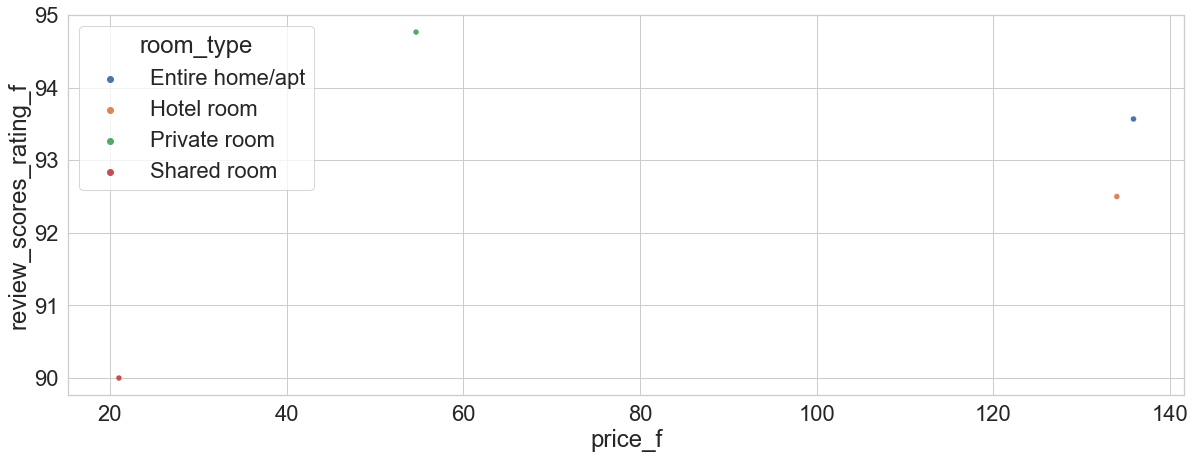

In [87]:
sns.scatterplot(data=df_mean, x='price_f', y='review_scores_rating_f', hue='room_type')

step 5 <a href="https://lab.karpov.courses/learning/85/module/1058/lesson/9062/26606/118458/">link</a>
<br>Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

<br>host_id – идентификатор хозяина (уникальный)
<br>host_verifications – какими способами хост подтвердил свой профиль
<br>Затем обработайте столбец host_verifications:

В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 

"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']

2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [68]:
query = """
SELECT
    DISTINCT host_id
    , host_verifications
    
FROM default.ldn_listings

WHERE experiences_offered != 'none'

ORDER BY host_id ASC
"""

df = ph.read_clickhouse(query=query, connection=connection)
df.head()

,host_id,host_verifications
0,6821,"['email', 'phone', 'facebook', 'reviews', 'jum..."
1,11431,"['email', 'phone', 'facebook', 'reviews', 'jum..."
2,27929,"['email', 'phone', 'reviews', 'jumio', 'govern..."
3,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
4,54987,"['email', 'phone', 'google', 'reviews', 'manua..."


In [69]:
df.host_verifications = df.host_verifications \
    .str.replace(pat=r'[\[\]]', repl='', regex=True) \
    .str.split(', ')

In [70]:
df = df.explode('host_verifications')

In [71]:
df.host_verifications.value_counts()

'phone'                    1361
'email'                    1345
'reviews'                  1309
'government_id'            1196
'jumio'                    1115
'offline_government_id'     469
'work_email'                279
'facebook'                  270
'selfie'                    252
'identity_manual'           227
'manual_offline'             70
'google'                     34
'kba'                        27
'manual_online'              16
'sent_id'                     6
Name: host_verifications, dtype: int64

step 6 <a href="https://lab.karpov.courses/learning/85/module/1058/lesson/9062/26606/118459/">link</a>
<br>Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

Пример трёх строк результирующей таблицы: в районе City of London для 7 объявлений указан тип впечатления business, для одного – family.

<pre>
    <code class="language-no-highlight">
+------------------------+---------------------+-------------------+
| neighbourhood_cleansed | experiences_offered | experiences_count |
+------------------------+---------------------+-------------------+
| City of London         | business            |                 7 |
| City of London         | family              |                 1 |
| City of London         | romantic            |                 1 |
+------------------------+---------------------+-------------------+
    </code>
</pre>

Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

Какой график получился?

In [73]:
query = """
SELECT
    neighbourhood_cleansed
    , experiences_offered
    , count() AS experiences_count
    
FROM default.ldn_listings

WHERE experiences_offered != 'none'

GROUP BY 
    neighbourhood_cleansed
    , experiences_offered
    
ORDER BY experiences_count DESC

LIMIT 100
"""

df = ph.read_clickhouse(query=query, connection=connection)
df.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [74]:
df.dtypes

neighbourhood_cleansed    object
experiences_offered       object
experiences_count         uint64
dtype: object

In [83]:
df_pivoted = df.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

In [90]:
df_pivoted

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


<AxesSubplot:xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

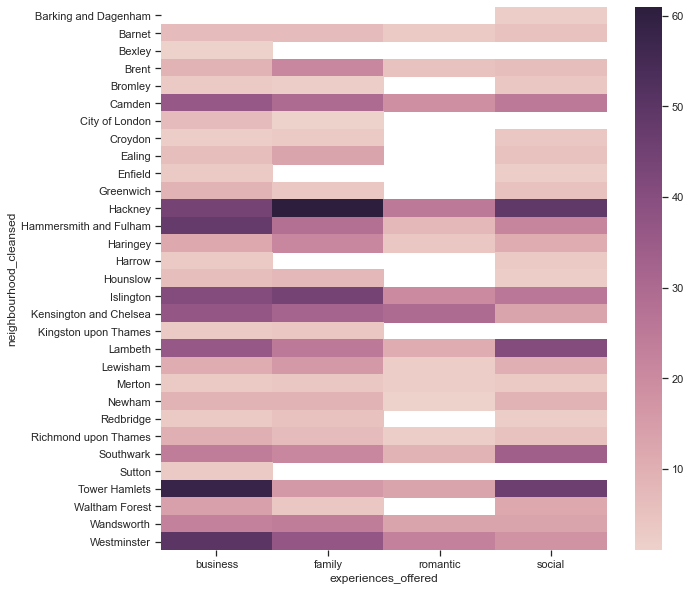

In [93]:
sns.set(
    font_scale = 1,
    style      = "ticks",
    rc         = {'figure.figsize':(10,10)}
)

sns.heatmap(data = df_pivoted, cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=True, yticklabels=True)

step 7 <a href="https://lab.karpov.courses/learning/85/module/1058/lesson/9062/26606/118460/">link</a>
<br>Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
<br>price – цена за ночь 
<br>experiences_offered – вид доступного впечатления (оставить не 'none')
<br>Пример части результирующей таблицы:

<pre>
    <code>
+-----------------+------------+
| room_type       | price_corr |
+-----------------+------------+
| Private room    |         65 |
| Entire home/apt |        100 |
| Entire home/apt |        ... |
+-----------------+------------+
    </code>
</pre>

Далее постройте два графика, используя distplot из библиотеки seaborn:

На первом отобразите исходные распределения цен для каждого типа жилья
<br>На втором – логарифмированные значения (np.log())

In [127]:
query = """
SELECT
    room_type
    , toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_f
    
FROM default.ldn_listings

WHERE experiences_offered != 'none'
"""

df = ph.read_clickhouse(query=query, connection=connection)
df.head()

,room_type,price_f
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


In [97]:
df.dtypes

room_type     object
price_f      float32
dtype: object

In [115]:
sns.set(
    font_scale =1,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

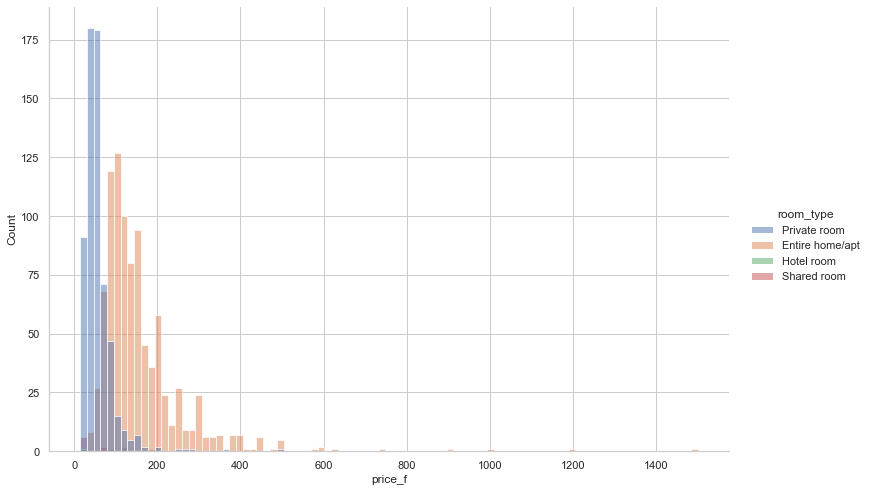

In [128]:
sns.displot(data = df, x='price_f', hue='room_type', height=7, aspect=1.5)

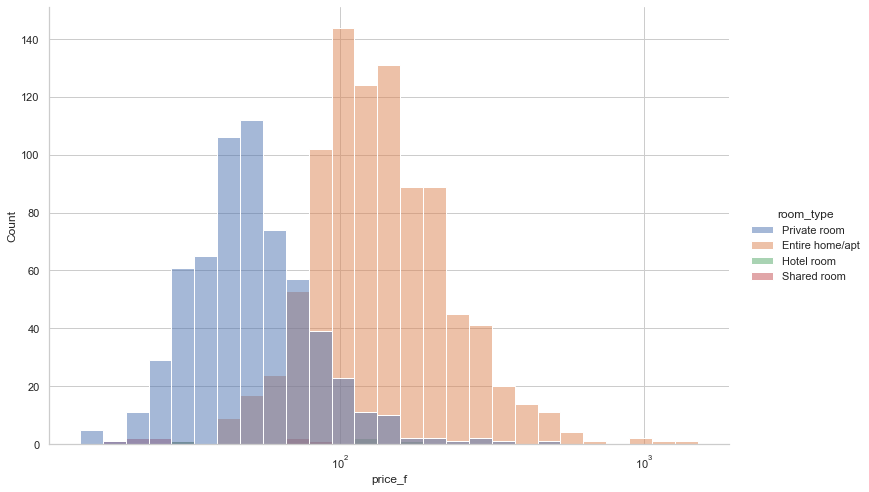

In [129]:
sns.displot(data = df, x='price_f', hue='room_type', log_scale=True, height=7, aspect=1.5)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


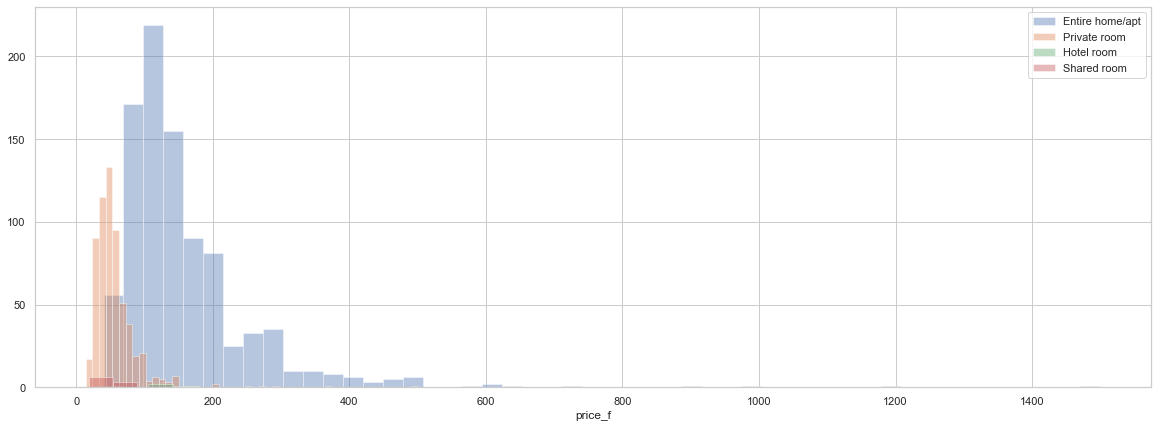

In [130]:
sns.distplot(df.query("room_type=='Entire home/apt'").price_f, kde=False, label='Entire home/apt')
sns.distplot(df.query("room_type=='Private room'").price_f, kde=False, label='Private room')
sns.distplot(df.query("room_type=='Hotel room'").price_f, kde=False, label='Hotel room')
sns.distplot(df.query("room_type=='Shared room'").price_f, kde=False, label='Shared room')
plt.legend()
plt.show()

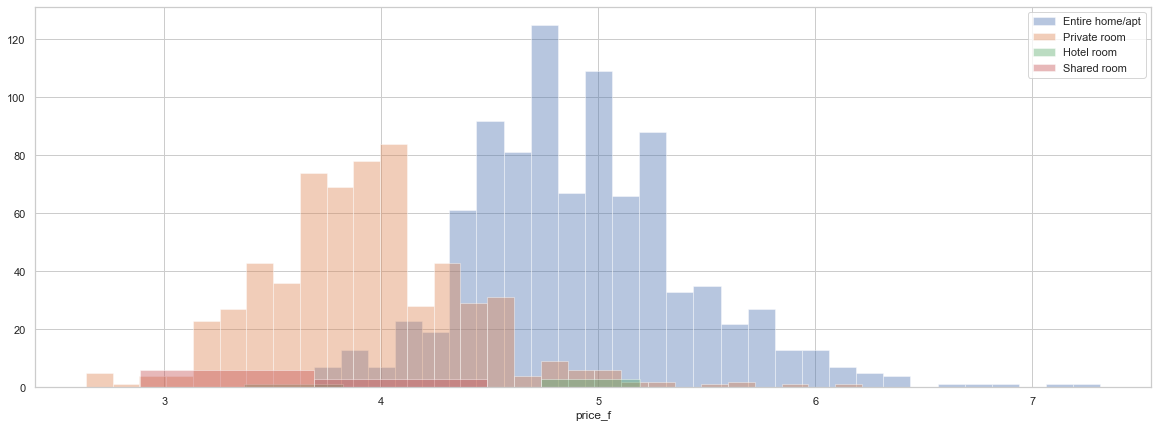

In [131]:
sns.distplot(np.log(df.query("room_type=='Entire home/apt'").price_f), kde=False, label='Entire home/apt')
sns.distplot(np.log(df.query("room_type=='Private room'").price_f), kde=False, label='Private room')
sns.distplot(np.log(df.query("room_type=='Hotel room'").price_f), kde=False, label='Hotel room')
sns.distplot(np.log(df.query("room_type=='Shared room'").price_f), kde=False, label='Shared room')
plt.legend()
plt.show()

step 8 <a href="https://lab.karpov.courses/learning/85/module/1058/lesson/9062/26606/118461/">link</a>
<br>Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
<br>price – цена за ночь
<br>first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
<br>Ограничение поставьте на 1000 строк.

Пример результирующей таблицы:

<pre>
    <code>
+-----------------+------------+------------+
| room_type       | price_corr |first_review|
+-----------------+------------+------------+
| Private room    |         65 | 2010-03-23 |
| Entire home/apt |        100 | 2012-01-01 |
+-----------------+------------+------------+
    </code>
</pre>

Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

Пример датафрейма, который будет служить основой для графика:
<pre>
    <code>
+-----------------+------------+------------+
| room_type       | avg_price  | year       |
+-----------------+------------+------------+
| Private room    |         54 | 2010       |
| Entire home/apt |        168 | 2012       |
+-----------------+------------+------------+
    </code>
</pre>

Hints: line plot; удалите последние 6 символов у значений в столбце даты, чтобы получить год, например, с помощью применения lambda-функции .

In [132]:
query = """
SELECT
    room_type
    , toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_f
    , first_review
    
FROM default.ldn_listings

WHERE first_review > '2010-01-01'

LIMIT 1000
"""

df = ph.read_clickhouse(query=query, connection=connection)
df.head()

,room_type,price_f,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [133]:
df.dtypes

room_type        object
price_f         float32
first_review     object
dtype: object

In [139]:
df.first_review = df.first_review.str.slice(0,4)

In [143]:
df_room_year = df.groupby(by=['room_type', 'first_review'], as_index=False) \
    .agg({'price_f':'mean'}) \
    .rename(columns={'price_f':'avg_price', 'first_review':'year'})

<AxesSubplot:xlabel='year', ylabel='avg_price'>

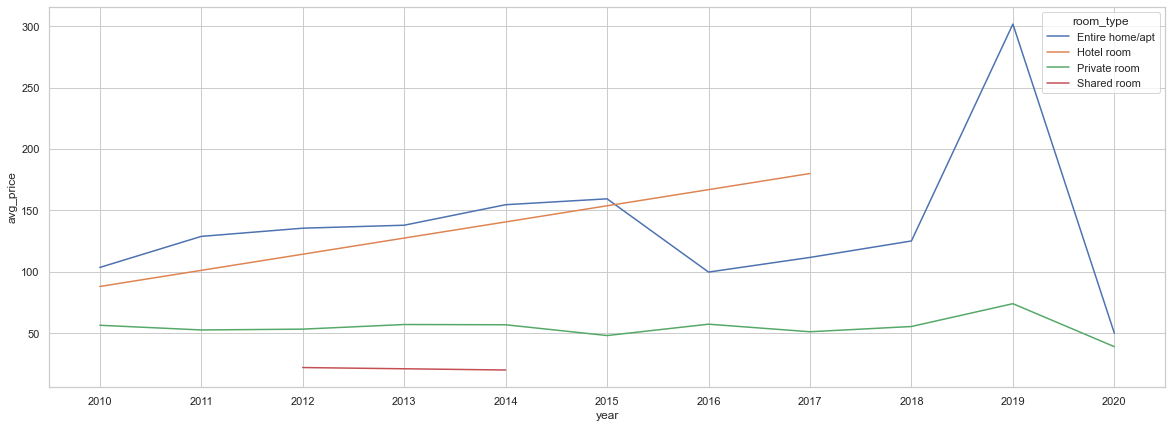

In [144]:
sns.lineplot(data=df_room_year, x='year', y='avg_price', hue='room_type')